In [1]:
import pyodbc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.gcf().subplots_adjust(bottom=-0.5) # doesn't work

<Figure size 432x288 with 0 Axes>

In [2]:
def initialize():
    '''Establish connection with our soccer DB.
    Output: cnxn, cursor (globally for convenience)'''

    server = 'imt563a.database.windows.net'
    database = 'IMT563'
    username = 'richardm'
    password = 'please_work_123'
    driver= '{SQL Server}'
    global cnxn, cursor
    cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = cnxn.cursor()

# All these functions first call initialize, then close connection and cursor
def output_rows(cursor):
    '''Print output from SELECT'''
    row = cursor.fetchone()
    while row:
        print(row)
        row = cursor.fetchone()
def get_constraints(table='Player_new_PK_SI'):
    initialize()
    sql = '''
    SELECT OBJECT_NAME(object_id) AS ConstraintName,
        OBJECT_NAME(parent_object_id) AS TableName,
        type_desc AS ConstraintType
    FROM sys.objects
    WHERE type_desc LIKE '%CONSTRAINT' AND OBJECT_NAME(parent_object_id) = \'''' + table_name + '''\'
    '''
    cursor.execute(sql)
    output_rows(cursor)
    cursor.close()
    cnxn.close()
def close():
    global cursor, cnxn
    cursor.close()
    cnxn.close()

In [3]:
initialize()

<BarContainer object of 3 artists>

[Text(0,0,''),
 Text(0,0,'no constraint'),
 Text(0,0,''),
 Text(0,0,'PK'),
 Text(0,0,''),
 Text(0,0,'PK + 1 index')]

Text(0,0.5,'Tuples/sec')

Text(0.5,1,'INSERT INTO Throughput')

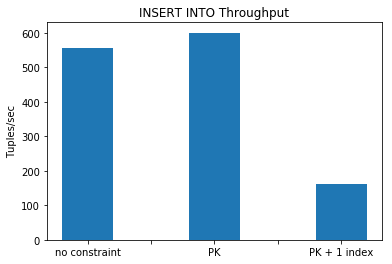

In [9]:
fig, ax = plt.subplots()
plt.bar([1,3,5],[556.48,600.24,161.456])
ax.set_xticklabels(['', "no constraint", '', "PK", '', "PK + 1 index"])
ax.set_ylabel("Tuples/sec")
ax.set_title("INSERT INTO Throughput")

### BULK INSERT Experiment with Player Table
Get average time-taken for each batch size of BULK INSERTS on the Player table (as dictionary)

In [13]:
## Bulk insert experiment -- return batch_avg dict
batches = [1, 5, 10, 20, 50, 100, 500, 1000, 2500, 6000, 10000, 11060] # Try with [11060] for quick test
def bulk_insert_experiment(table_name, sql_stmt):
    initialize()
    print("----\nRunning batches for", table_name)
    # Keep track of each batch-time to compute averages
    batch_times = {batch:[] for batch in batches}

    for i in range(5):
        # Pause to let our DTU's catch up
        time.sleep(5) # doesn't seem to be doing anything
        for batch_size in batches:
            cursor.execute('''TRUNCATE TABLE ''' + table_name)
            cursor.commit()
            #print(batch_size)

            start = time.time()

            first_row = 2
            last_row = 2 + batch_size - 1

            # BULK INSERT <batch_size> rows from csv
            sql = sql_stmt.format(table_name, first_row, last_row)
            cursor.execute(sql)

            cursor.commit()
            end = time.time()
            total_time = end - start
            # Record time and append it to dict
            #print(total_time, "seconds")
            batch_times[batch_size].append(total_time)

    # Output averages
    batch_avg = {}
    print("** AVERAGES **")
    for batch in batches:
        times = batch_times[batch]
        print("Batch:", batch, "Avg:", sum(times)/len(times))
        batch_avg[batch] = sum(times)/len(times)
        
    # Close cursor and connection
    close()
    return batch_avg

In [14]:
t1 = time.time()
sql_stmt = '''
        BULK INSERT {}
        FROM 'Player.csv'
        WITH ( DATA_SOURCE = 'imt563ian_blobdatasource', FORMAT='CSV', FIRSTROW={}, LASTROW={});'''
A = bulk_insert_experiment("Player_new_No_Constraint", sql_stmt)
B = bulk_insert_experiment("Player_new_PK", sql_stmt)
C = bulk_insert_experiment("Player_new_PK_SI", sql_stmt)
print("Time taken", time.time() - t1)

----
Running batches for Player_new_No_Constraint
** AVERAGES **
Batch: 1 Avg: 0.43114304542541504
Batch: 5 Avg: 0.36504926681518557
Batch: 10 Avg: 0.3550106048583984
Batch: 20 Avg: 0.333685302734375
Batch: 50 Avg: 0.35270466804504397
Batch: 100 Avg: 0.3421631813049316
Batch: 500 Avg: 0.3687741279602051
Batch: 1000 Avg: 0.33364248275756836
Batch: 2500 Avg: 0.4051381587982178
Batch: 6000 Avg: 0.6624069690704346
Batch: 10000 Avg: 1.5832300186157227
Batch: 11060 Avg: 1.9114573001861572
----
Running batches for Player_new_PK
** AVERAGES **
Batch: 1 Avg: 0.3503002643585205
Batch: 5 Avg: 0.33211002349853513
Batch: 10 Avg: 0.32664804458618163
Batch: 20 Avg: 0.33842968940734863
Batch: 50 Avg: 0.3333582401275635
Batch: 100 Avg: 0.3392296314239502
Batch: 500 Avg: 0.3385298728942871
Batch: 1000 Avg: 0.3646674633026123
Batch: 2500 Avg: 0.34212536811828614
Batch: 6000 Avg: 0.6054218292236329
Batch: 10000 Avg: 1.8253232479095458
Batch: 11060 Avg: 1.9477821826934814
----
Running batches for Player_ne

## Plotting

In [81]:
# First convert dictionary into sorted lists
A_vals = [A[key] for key in sorted(A.keys())]
B_vals = [B[key] for key in sorted(B.keys())]
C_vals = [C[key] for key in sorted(C.keys())]
print('no constraints\n', A_vals,'\n')
print('PK\n', B_vals,'\n')
print('PK + 1 index\n', C_vals)

df = pd.DataFrame({'none':A_vals, 'PK':B_vals, 'PK & Index':C_vals})
df

no constraints
 [0.43114304542541504, 0.36504926681518557, 0.3550106048583984, 0.333685302734375, 0.35270466804504397, 0.3421631813049316, 0.3687741279602051, 0.33364248275756836, 0.4051381587982178, 0.6624069690704346, 1.5832300186157227, 1.9114573001861572] 

PK
 [0.3503002643585205, 0.33211002349853513, 0.32664804458618163, 0.33842968940734863, 0.3333582401275635, 0.3392296314239502, 0.3385298728942871, 0.3646674633026123, 0.34212536811828614, 0.6054218292236329, 1.8253232479095458, 1.9477821826934814] 

PK + 1 index
 [0.4527853488922119, 0.3338538646697998, 0.3293473243713379, 0.33818721771240234, 0.3352212429046631, 0.3404698371887207, 0.3657816410064697, 0.36032938957214355, 0.6904160499572753, 2.495271348953247, 4.035994386672973, 4.55908899307251]


,none,PK,PK & Index
0,0.431143,0.350300,0.452785
1,0.365049,0.332110,0.333854
2,0.355011,0.326648,0.329347
3,0.333685,0.338430,0.338187
4,0.352705,0.333358,0.335221
5,0.342163,0.339230,0.340470
6,0.368774,0.338530,0.365782
7,0.333642,0.364667,0.360329
8,0.405138,0.342125,0.690416
9,0.662407,0.605422,2.495271


In [82]:
df = pd.DataFrame({'none':A, 'PK':B, 'PK & Index':C})
# Drop last row of baselines
df = df.apply(lambda x: x.index/x)
df

,none,PK,PK & Index
1,2.319416,2.854694,2.208552
5,13.696781,15.055252,14.976613
10,28.168173,30.613990,30.363083
20,59.936712,59.096470,59.138841
50,141.761662,149.988793,149.155225
100,292.258213,294.785569,293.711774
500,1355.843488,1476.974530,1366.935745
1000,2997.220233,2742.224357,2775.238515
2500,6170.734466,7307.262872,3621.005045
6000,9057.875717,9910.445429,2404.548108


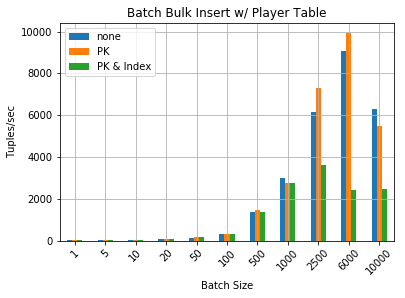

In [91]:
df = pd.DataFrame({'none':A, 'PK':B, 'PK & Index':C})
# Drop last row of baselines
df = df.iloc[:-1,:]

batches = [1, 5, 10, 20, 50, 100, 500, 1000, 2500, 6000, 10000]#, 11060]

df = df.apply(lambda x: x.index/x)

ax = df.plot(kind='bar', grid=True)
_=ax.set_title("Batch Bulk Insert w/ Player Table")
_=ax.set_ylabel("Tuples/sec")
_=ax.set_xlabel("Batch Size")
_=ax.set_xticklabels(batches, rotation=45)


# xlocs = np.arange(len(batches))
# width = 0.35       # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(xlocs, A, width, color='r')
# rects2 = ax.bar(xlocs + width, B, width, color='y')
# rects3 = ax.bar(xlocs + 2*width, C, width, color='b')

# # add some text for labels, title and axes ticks
# ax.set_ylabel('Tuples/sec')
# ax.set_title('Batch Bulk Insert w/ Player Table')
# ax.set_xticks(xlocs + width / 2)
# ax.set_xticklabels(batches)

# ax.legend((rects1[0], rects2[0], rects3[0]), ('none', 'PK', 'PK & Index'))

In [58]:
np.arange(len(batches))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [70]:
len(A_vals)

12

In [94]:
df['none']

1           2.319416
5          13.696781
10         28.168173
20         59.936712
50        141.761662
100       292.258213
500      1355.843488
1000     2997.220233
2500     6170.734466
6000     9057.875717
10000    6316.201615
Name: none, dtype: float64

In [97]:
import csv

In [99]:

df.to_csv("Bulk Batch Insert w Player.csv")

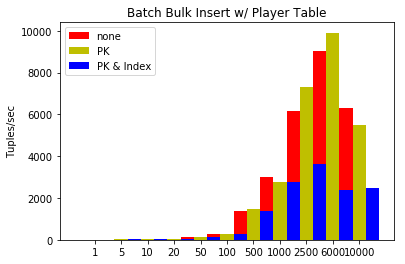

In [95]:
xlocs = np.arange(len(batches))
width = 0.5       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(xlocs, df['none'], width, color='r')
rects2 = ax.bar(xlocs + width, df['PK'], width, color='y')
rects3 = ax.bar(xlocs + 2*width, df['PK & Index'], width, color='b')

# add some text for labels, title and axes ticks
_=ax.set_ylabel('Tuples/sec')
_=ax.set_title('Batch Bulk Insert w/ Player Table')
_=ax.set_xticks([x + width for x in xlocs])
_=ax.set_xticklabels(batches)
#ax.xaxis.set_ticks(np.arange(start, end, 0.712123))

_=ax.legend((rects1[0], rects2[0], rects3[0]), ('none', 'PK', 'PK & Index'))

# 9B 
### Re-run BULK INSERT on Match Table with 1, 2, 3, and 4 non-clustered indexes (this is in addition to the clustered primary key

### Modified BULK INSERT code

In [11]:
def bulk_insert_INDEXES_experiment(table_name, sql_stmt):
    initialize()
    print("----\nRunning batches for", table_name)
    # Keep track of each batch-time but don't compute averages this time
    batch_times = {batch:[] for batch in batches}

    cursor.execute('''TRUNCATE TABLE ''' + table_name)
    cursor.commit()

    start = time.time()

    batch_size = 10000
    first_row = 2
    last_row = 2 + batch_size - 1

    # BULK INSERT <batch_size> rows from csv
    sql = sql_stmt.format(table_name, first_row, last_row)
    cursor.execute(sql)

    cursor.commit()
    end = time.time()
    total_time = end - start
    # Record time and append it to dict
    #print(total_time, "seconds")
    batch_times[batch_size].append(total_time) 
        
    # Close cursor and connection
    close()
    return batch_times

In [19]:
initialize()

In [ ]:


## match_api_id, home_team_api_id, away_team_api_id, date

# Starts with 1 index
initialize()
batches = [10000]
sql_stmt = '''
        BULK INSERT {}
        FROM 'Match.csv'
        WITH ( DATA_SOURCE = 'imt563ian_blobdatasource', FORMAT='CSV', FIRSTROW={}, LASTROW={});'''
# ... Retrieve time taken for adding 10000 records to Match_new_PK_SI
IX_1 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI_copy", sql_stmt)

----
Running batches for MATCH_new_PK_SI_copy


In [27]:


## SQL being executed and batches (just 10000 in this case)
initialize()
batches = [10000]
sql_stmt = '''
        BULK INSERT {}
        FROM 'Match.csv'
        WITH ( DATA_SOURCE = 'imt563ian_blobdatasource', FORMAT='CSV', FIRSTROW={}, LASTROW={});'''

# Add a 2nd index
print("\n---\nAdding second index: home_team_api_id")
initialize()
#cursor.execute('''
#    CREATE NONCLUSTERED INDEX match_index2 ON dbo.MATCH_new_PK_SI (home_team_api_id)''')
#cursor.commit()
# Bulk insert 10000 rows
IX_2 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI", sql_stmt)

# Add 3rd index
print("\n---\nAdding third index: away_team_api_id")
initialize()
cursor.execute('''
    CREATE NONCLUSTERED INDEX match_third_index ON dbo.MATCH_new_PK_SI (away_team_api_id)''')
cursor.commit()
# Bulk insert 10000 rows
IX_3 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI", sql_stmt)

# Add 4th index
print("\n---\nAdding fourth index: player_fifa_api_id")
initialize()
cursor.execute('''
    CREATE NONCLUSTERED INDEX match_fourth_index ON dbo.MATCH_new_PK_SI (date)''')
cursor.commit()
# Bulk insert 10000 rows
IX_4 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI", sql_stmt)




---
Adding second index: home_team_api_id

---
Adding third index: away_team_api_id


----
Running batches for MATCH_new_PK_SI

---
Adding fourth index: player_fifa_api_id


----
Running batches for MATCH_new_PK_SI


## Plot

In [36]:
IX_2, IX_3, IX_4

({10000: 205.82607593536378},
 {10000: 204.6538074016571},
 {10000: 200.16650414466858})

In [39]:
df = pd.DataFrame({'1': {10000:150} , '2':IX_2, '3':IX_3, '4':IX_4}) # Just made up one for IX_1
# Drop last row of baselines

In [100]:
IX_2, IX_3, IX_4

({10000: 205.82607593536378},
 {10000: 204.6538074016571},
 {10000: 200.16650414466858})

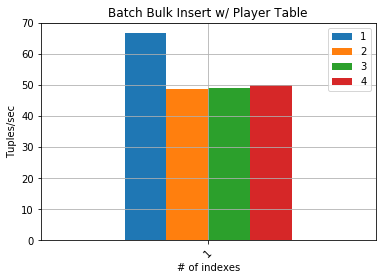

In [49]:
df = pd.DataFrame({1: 150 , 2:IX_2[10000], 3:IX_3[10000], 4:IX_4[10000]}, index=[10000]) # Just made up one for IX_1
# Drop last row of baselines

df = df.apply(lambda x: x.index/x)

ax = df.plot(kind='bar', grid=True)
_=ax.set_title("Batch Bulk Insert w/ Player Table")
_=ax.set_ylabel("Tuples/sec")
_=ax.set_xlabel("# of indexes")
_=ax.set_xticklabels([1,2,3,4], rotation=45)